In [42]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

IMG_SIZE = 256
BATCH_SIZE = 32
TEST_SPLIT = 0.1
SEED = random.randrange(100)

IMAGES_PATH = "data"


def load_dataset():
    x_train, x_test = keras.utils.image_dataset_from_directory(
        f"{IMAGES_PATH}/images",
        labels=None,
        label_mode=None,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        seed=SEED,
        validation_split=TEST_SPLIT,
        subset="both",
    )
    y_train, y_test = keras.utils.text_dataset_from_directory(
        f"{IMAGES_PATH}/labels",
        labels=None,
        label_mode=None,
        batch_size=BATCH_SIZE,
        seed=SEED,
        validation_split=TEST_SPLIT,
        subset="both",
    )
    return x_train, x_test, y_train, y_test


Found 433 files belonging to 1 classes.
Using 390 files for training.
Using 43 files for validation.
Found 433 files belonging to 1 classes.
Using 390 files for training.
Using 43 files for validation.
Finished loading data
x_train element_spec: TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)
y_train element_spec: TensorSpec(shape=(None,), dtype=tf.float32, name=None)
x_test element_spec: TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)
y_test element_spec: TensorSpec(shape=(None,), dtype=tf.float32, name=None)


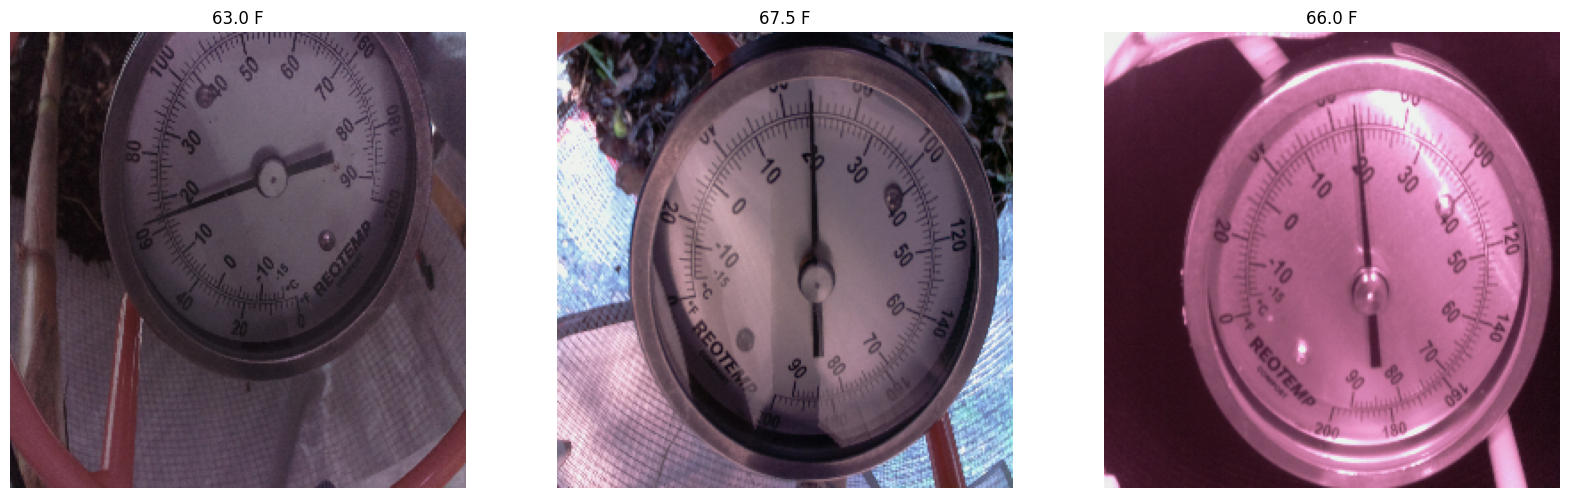

In [43]:
x_train, x_test, y_train, y_test = load_dataset()

print("Finished loading data")

y_train = y_train.map(lambda x: tf.strings.to_number(x))
y_test = y_test.map(lambda x: tf.strings.to_number(x))


def print_first_images(images, labels):
    """ Print out 3 images with labels """
    plt.figure(figsize=(20, 20))
    i = 0
    images_first_3 = list(images.take(3))
    labels_first_3 = list(labels.take(3))
    for images, labels in zip(images_first_3, labels_first_3):
        i += 1
        image = images[0, ...]
        label = labels[0, ...]
        plt.subplot(1, 3, i)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(f"{label.numpy()} F")
        plt.axis("off")


print_first_images(x_train, y_train)

print(f"x_train element_spec: {x_train.element_spec}")
print(f"y_train element_spec: {y_train.element_spec}")
print(f"x_test element_spec: {x_test.element_spec}")
print(f"y_test element_spec: {y_test.element_spec}")
# print(f"x_test: {list(x_test)}")
# print(f"y_test: {list(y_test)}")


train_ds = tf.data.Dataset.zip((x_train, y_train))
test_ds = tf.data.Dataset.zip((x_test, y_test))


In [44]:

DENSE_1_UNITS = 'dense_1_units'
DENSE_2_UNITS = 'dense_2_units'
DENSE_3_UNITS = 'dense_3_units'
LEARNING_RATE = 'learning_rate'


def model_builder(hp):
    model = keras.Sequential([
        keras.layers.Conv2D(3, 3, activation='relu'),
        keras.layers.Conv2D(3, 3, activation='relu'),
        keras.layers.MaxPooling2D(2),
        keras.layers.Conv2D(3, 3, activation='relu'),
        keras.layers.Conv2D(3, 3, activation='relu'),
        keras.layers.MaxPooling2D(2),
        keras.layers.Conv2D(3, 3, activation='relu'),
        keras.layers.Conv2D(3, 3, activation='relu'),
        keras.layers.Flatten(),
    ])

    # Tune the number of units in the 1st Dense layer
    # Choose an optimal value between 256-512
    hp_dense1_units = hp.Int(DENSE_1_UNITS, min_value=256, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_dense1_units, activation='relu'))

    # Tune the number of units in the 2nd Dense layer
    # Choose an optimal value between 64-256
    hp_dense2_units = hp.Int(DENSE_2_UNITS, min_value=64, max_value=256, step=32)
    model.add(keras.layers.Dense(units=hp_dense2_units, activation='relu'))

    # Tune the number of units in the 3rd Dense layer
    # Choose an optimal value between 1-64
    hp_dense3_units = hp.Int(DENSE_3_UNITS, min_value=1, max_value=64, step=8)
    model.add(keras.layers.Dense(units=hp_dense3_units, activation='relu'))

    model.add(keras.layers.Dense(1))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice(LEARNING_RATE, values=[1e-2, 1e-3, 1e-4])
    optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)

    model.compile(
        optimizer=optimizer,
        loss="mean_squared_error",
    )

    # model_history = model.fit(train_ds, epochs=EPOCHS, shuffle=True, validation_data=test_ds)
    return model

In [45]:

EPOCHS = 50


def auto_tune_parameters():
    tuner = kt.Hyperband(model_builder,
                         objective='loss',
                         max_epochs=10,
                         factor=3,
                         directory='.tuner_data',
                         overwrite=True,
                         project_name='temperature_dial')

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    tuner.search(train_ds, epochs=EPOCHS, shuffle=True, validation_data=test_ds, callbacks=[stop_early])

    # Get the optimal hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"""
    The hyperparameter search is complete.
    The optimal number of units in the
    1st densely-connected layer is {best_hps.get(DENSE_1_UNITS)}
    2nd densely-connected layer is {best_hps.get(DENSE_2_UNITS)}
    3rd densely-connected layer is {best_hps.get(DENSE_3_UNITS)}
    and the optimal learning rate for the optimizer is {best_hps.get(LEARNING_RATE)}.
    """)
    return tuner, best_hps


tuner, best_hps = auto_tune_parameters()

Trial 30 Complete [00h 00m 49s]
loss: 994.4757080078125

Best loss So Far: 21.33847999572754
Total elapsed time: 00h 10m 14s
INFO:tensorflow:Oracle triggered exit

    The hyperparameter search is complete.
    The optimal number of units in the
    1st densely-connected layer is 352
    2nd densely-connected layer is 128
    3rd densely-connected layer is 9
    and the optimal learning rate for the optimizer is 0.01.
    


In [46]:
def train_model():
    # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
    hypermodel = tuner.hypermodel.build(best_hps)
    history = hypermodel.fit(train_ds, epochs=EPOCHS, shuffle=True, validation_data=test_ds)
    return hypermodel, history

hypermodel, history = train_model()


Epoch 1/50
13/13 [==============================] - 5s 174ms/step - loss: 5544.6943 - val_loss: 1692.3610
Epoch 2/50
13/13 [==============================] - 5s 166ms/step - loss: 1902.3560 - val_loss: 629.3207
Epoch 3/50
13/13 [==============================] - 5s 169ms/step - loss: 858.4757 - val_loss: 414.4574
Epoch 4/50
13/13 [==============================] - 5s 167ms/step - loss: 365.1430 - val_loss: 337.9218
Epoch 5/50
13/13 [==============================] - 5s 168ms/step - loss: 142.1970 - val_loss: 231.5881
Epoch 6/50
13/13 [==============================] - 5s 168ms/step - loss: 61.4710 - val_loss: 228.6663
Epoch 7/50
13/13 [==============================] - 5s 168ms/step - loss: 31.0915 - val_loss: 194.3435
Epoch 8/50
13/13 [==============================] - 5s 171ms/step - loss: 14.5498 - val_loss: 181.1104
Epoch 9/50
13/13 [==============================] - 5s 169ms/step - loss: 11.8095 - val_loss: 180.6704
Epoch 10/50
13/13 [==============================] - 5s 171ms/ste

In [47]:
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % best_epoch)

eval_result = hypermodel.evaluate(test_ds)
print("[test loss]:", eval_result)


Best epoch: 21
2/2 [==============================] - 0s 25ms/step - loss: 204.2787
[test loss]: 204.27870178222656


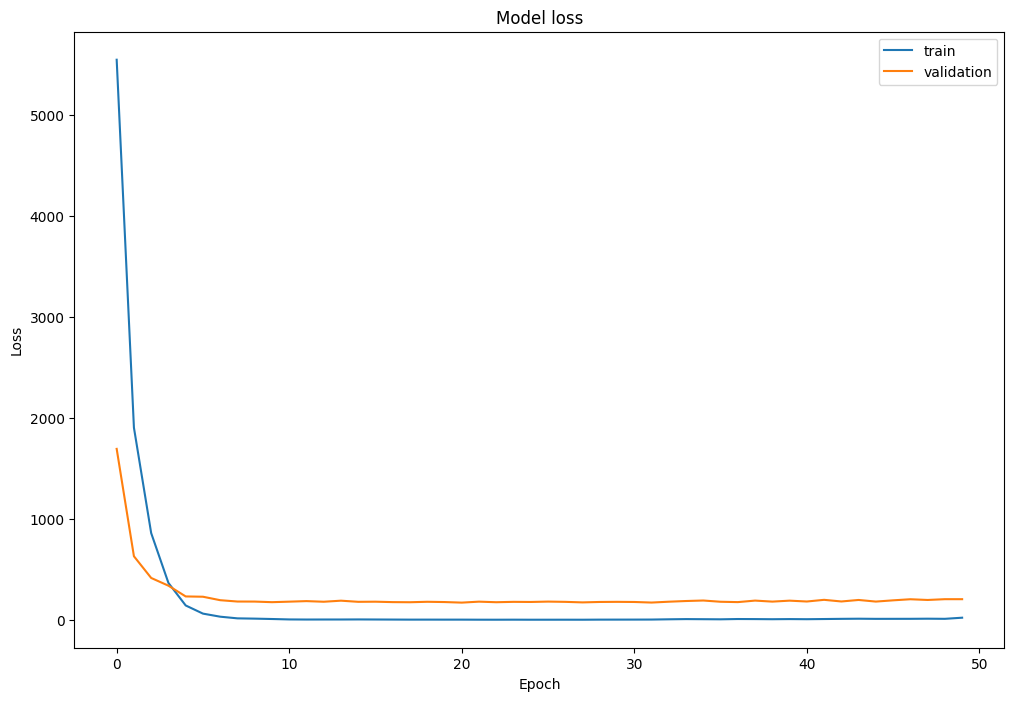

In [48]:
def visualize_loss(history):
    df_loss = pd.DataFrame(history.history)
    df_loss = df_loss[['loss', 'val_loss']]
    df_loss.rename(columns={'loss': 'train', 'val_loss': 'validation'}, inplace=True)
    df_loss.plot(title='Model loss', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Loss')


visualize_loss(history)
